# Aftermath of a large recruitment event

Explores how different policies interact with environment in the timesteps following a large recruitment event. Initially assumes that the initial recruitment event is isolated.

In [117]:
import rl4fisheries

from rl4fisheries import AsmEnv, FMsy, PrecautionaryPrinciple
from rl4fisheries.envs.asm_fns import get_r_devs_v2 # lognormal r-deviations with no large recruitments

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from huggingface_hub import hf_hub_download
from numbers import Number
from skopt import load
from stable_baselines3 import PPO


## Files and configs

In [118]:
## UM1

CFG_UM1_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}

## UM2

CFG_UM2_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}

## UM3

CFG_UM3_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}

CFG = {
    'um1': CFG_UM1_2o, 'um2': CFG_UM2_2o, 'um3': CFG_UM3_2o,
}


In [119]:
cr_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/cr-UM1-noise01.pkl")
cr_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/cr-UM2-noise01.pkl")
cr_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/cr-UM3-noise01.pkl")

msy_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/msy-UM1-noise01.pkl")
msy_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/msy-UM2-noise01.pkl")
msy_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/msy-UM3-noise01.pkl")

cr_UM1 = load(cr_UM1_file)
cr_UM2 = load(cr_UM2_file)
cr_UM3 = load(cr_UM3_file)

msy_UM1 = load(msy_UM1_file)
msy_UM2 = load(msy_UM2_file)
msy_UM3 = load(msy_UM3_file)

In [120]:
base_fname = "sb3/rl4fisheries/post-review-results/PPO-AsmEnv-"
repo = "boettiger-lab/rl4eco"

PPO_2o_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM1-256-64-16-noise0.1-chkpnt2.zip")
PPO_bm_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM1-64-32-16-noise0.1-chkpnt2.zip")

PPO_2o_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM2-256-64-16-noise0.1-chkpnt4.zip")
PPO_bm_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM2-64-32-16-noise0.1-chkpnt4.zip")

PPO_2o_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM3-256-64-16-noise0.1-chkpnt2.zip")
PPO_bm_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM3-64-32-16-noise0.1-chkpnt4.zip")

PPO_2o_UM1 = PPO.load(PPO_2o_UM1_file, device='cpu')
PPO_bm_UM1 = PPO.load(PPO_bm_UM1_file, device='cpu')

PPO_2o_UM2 = PPO.load(PPO_2o_UM2_file, device='cpu')
PPO_bm_UM2 = PPO.load(PPO_bm_UM2_file, device='cpu')

PPO_2o_UM3 = PPO.load(PPO_2o_UM3_file, device='cpu')
PPO_bm_UM3 = PPO.load(PPO_bm_UM3_file, device='cpu')

In [121]:
fmsy_UM1 = msy_UM1.x[0]
fmsy_UM2 = msy_UM2.x[0]
fmsy_UM3 = msy_UM3.x[0]

msy_rew_UM1 = -msy_UM1.fun
msy_rew_UM2 = -msy_UM2.fun
msy_rew_UM3 = -msy_UM3.fun

fmsy_avg_rewards = {
    'um1': msy_rew_UM1/1000,
    'um2': msy_rew_UM2/1000,
    'um3': msy_rew_UM3/1000,
}

fmsy_vals = {
    'um1': fmsy_UM1,
    'um2': fmsy_UM2,
    'um3': fmsy_UM3,
}

bmsy = fmsy_avg_rewards['um1'] / fmsy_vals['um1'] 


def get_dfo_pol(fmsy, bmsy, env_cfg):
    return PrecautionaryPrinciple(
        env = AsmEnv(config=env_cfg),
        x1 = 0.4 * bmsy,
        x2 = 0.8 * bmsy,
        y2 = fmsy,
    )

def from_radius_theta(radius, theta, y2):
    x1 = radius * np.sin(theta)
    x2 = radius * np.cos(theta)
    return {'x1': x1, 'x2': x2, 'y2': y2}  

In [122]:
oPPs = {
    f'um{idx+1}': PrecautionaryPrinciple(
        env = AsmEnv(CFG[f'um{idx+1}']),
        **from_radius_theta(*cr_radial_params),
    ) for idx, cr_radial_params in enumerate([cr_UM1.x, cr_UM2.x, cr_UM3.x])
}

cPPs ={
     f'um{idx+1}': get_dfo_pol(fmsy, bmsy, env_cfg = CFG[f'um{idx+1}']) for idx, fmsy in enumerate([fmsy_UM1, fmsy_UM2, fmsy_UM3])
}

FMSYs = {
    f'um{idx+1}': FMsy(
        env = AsmEnv(CFG[f'um{idx+1}']),
        mortality = fmsy[0],
    ) for idx, fmsy in enumerate([msy_UM1.x, msy_UM2.x, msy_UM3.x])
}

UNCTRL = FMsy(
        env = AsmEnv(CFG['um1']),
        mortality = 0,
    )


UM1_Agents = {
    'Fmsy': FMSYs['um1'],
    'oPP': oPPs['um1'],
    'cPP': cPPs['um1'],
    '1RL': PPO_bm_UM1,
    '2RL': PPO_2o_UM1,
    'No fishing': UNCTRL,
}

UM2_Agents = {
    'Fmsy': FMSYs['um2'],
    'oPP': oPPs['um2'],
    'cPP': cPPs['um2'],
    '1RL': PPO_bm_UM2,
    '2RL': PPO_2o_UM2,
    'No fishing': UNCTRL,
}

UM3_Agents = {
    'Fmsy': FMSYs['um3'],
    'oPP': oPPs['um3'],
    'cPP': cPPs['um3'],
    '1RL': PPO_bm_UM3,
    '2RL': PPO_2o_UM3,
    'No fishing': UNCTRL,
}

AGENT_NAMES = list(UM1_Agents.keys())



## Reproducible noise

In [123]:

N_SIMS = 500
N_STEPS = 30

def aftermath_rdevs(num_steps):
    rdevs = get_r_devs_v2(num_steps)
    rdevs[0] = np.random.uniform(10, 30)
    return rdevs

rdev_list = [aftermath_rdevs(N_STEPS) for _ in range(N_SIMS)]

UM1_envs = [
    AsmEnv(
        config = {**CFG_UM1_2o, 'reproducibility_mode': True, 'r_devs': rdev_list[i], 'n_year':N_STEPS}
    )
    for i in range(N_SIMS)
]

UM2_envs = [
    AsmEnv(
        config = {**CFG_UM2_2o, 'reproducibility_mode': True, 'r_devs': rdev_list[i], 'n_year':N_STEPS}
    )
    for i in range(N_SIMS)
]

UM3_envs = [
    AsmEnv(
        config = {**CFG_UM3_2o, 'reproducibility_mode': True, 'r_devs': rdev_list[i], 'n_year':N_STEPS}
    )
    for i in range(N_SIMS)
]

## Simulation

In [124]:
def safe_predict(agent, obs, observed_var):
    if observed_var == '2o':
        if len(obs) == 2:
            return agent.predict(obs)
    if observed_var == 'mw':
        if len(obs) == 2:
            return agent.predict(np.float32([obs[1]]))
        if len(obs) == 1:
            return agent.predict(obs)
    if observed_var == 'bm':
        if len(obs) == 2:
            # print(obs[0], agent.predict(np.float32([obs[0]]))) ###########
            return agent.predict(np.float32([obs[0]]))
        if len(obs) == 1:
            return agent.predict(obs)
    print(f'problem in safe_predict. obs: {obs}, observed_var: {observed_var}')
    return

def simulate_aftermath(agent, asm, num_steps, observed_var):

    mwts = []
    bmss = []
    #
    morts = []
    rews = []
    ssbs = []
    ts = []

    # reset / first step
    obs, info = asm.reset()

    # following steps
    for t in range(num_steps):
        #
        (bms, mwt) = obs
        bms = asm.bound * (bms + 1) / 2
        min_wt = asm.parameters["min_wt"]
        max_wt = asm.parameters["max_wt"]
        mwt = min_wt + (max_wt - min_wt) * (mwt + 1) / 2
        action, action_info = safe_predict(agent, obs, observed_var)
        mort = asm.mortality_units(action)[0]
        #
        ssb = asm.ssb
        new_obs, rew, term, trunc, info = asm.step(action)
        #
        # not sure why this is necessary for some Fmsy agents... probably some typo somewhere
        if not isinstance(mort, Number):
            mort = mort[0]
        if not isinstance(rew, Number):
            rew = rew[0]
        #
        mwts.append(mwt)
        bmss.append(bms)
        morts.append(mort)
        rews.append(rew)
        ssbs.append(ssb)
        ts.append(t)
        #
        obs = new_obs

    return {'t': ts, 'mwt':mwts, 'bms': bmss, 'mort': morts, 'rew': rews, 'ssb': ssbs}

def simulate_aftermath_df(agent, asm, num_steps, observed_var, agent_name, sim_id):
    simulate_aftermath(agent, asm, num_steps, observed_var)
    aftermath_df = pd.DataFrame(simulate_aftermath(agent, asm, num_steps, observed_var))
    aftermath_df['sim_id'] = sim_id
    aftermath_df['agent'] = agent_name
    # print(aftermath_df.head())
    return aftermath_df


SIMS_CHOICE = {
    'um1': {'agents': UM1_Agents, 'envs': UM1_envs},
    'um2': {'agents': UM2_Agents, 'envs': UM2_envs},
    'um3': {'agents': UM3_Agents, 'envs': UM3_envs},
}

def generate_simulations(
        num_steps: int, 
        um: str, # = um1, um2 or um3
    ):
    agents_to_simulate = (SIMS_CHOICE[um])['agents']
    reprod_env_list = (SIMS_CHOICE[um])['envs']
    num_sims = len(reprod_env_list)
    #
    aftermath_dfs = {}
    #
    for agent_name, agent in agents_to_simulate.items():
        #
        observed_var = "2o" if agent_name == "2RL" else "bm"
        #
        aftermath_dfs[agent_name] = pd.concat(
            [
                simulate_aftermath_df(
                    agent, 
                    asm=reprod_env_list[i], num_steps=num_steps, observed_var=observed_var, agent_name=agent_name, sim_id=i) 
                for i in range(num_sims)
            ],
            ignore_index=True,
        )
    #
    # I have no clue why the Fmsy df was getting 1-D arrays as entries for morts and rews... 
    # I couldn't fix it inside the simulation generation function
    # whelp, here's the non-elegant but will-do fix for now...
    #
    # aftermath_dfs['Fmsy']['mort'] = aftermath_dfs['Fmsy'].apply(
    #     axis=1,
    #     func=lambda row: row['mort'][0]
    # )

    # aftermath_dfs['Fmsy']['rew'] = aftermath_dfs['Fmsy'].apply(
    #     axis=1,
    #     func=lambda row: row['rew'][0]
    # )
    #
    return aftermath_dfs


In [125]:
simulation_df_UM1 = pd.concat(
    list(
        generate_simulations(
            num_steps = 30, 
            um="um1",
        ).values()
    )
)

simulation_df_UM2 = pd.concat(
    list(
        generate_simulations(
            num_steps = 30, 
            um="um2",
        ).values()
    )
)

simulation_df_UM3 = pd.concat(
    list(
        generate_simulations(
            num_steps = 30, 
            um="um3",
        ).values()
    )
)

In [126]:
np.unique(simulation_df_UM1.agent)

array(['1RL', '2RL', 'Fmsy', 'No fishing', 'cPP', 'oPP'], dtype=object)

## Melt for seaborn

In [127]:
melted_UM1_df = simulation_df_UM1.melt(id_vars=['t', 'sim_id', 'agent'], value_vars=['mwt', 'bms', 'mort', 'rew', 'ssb'])

melted_UM2_df = simulation_df_UM2.melt(id_vars=['t', 'sim_id', 'agent'], value_vars=['mwt', 'bms', 'mort', 'rew', 'ssb'])

melted_UM3_df = simulation_df_UM3.melt(id_vars=['t', 'sim_id', 'agent'], value_vars=['mwt', 'bms', 'mort', 'rew', 'ssb'])

In [128]:
nice_name = {
    'mort': 'Instant. Fishing\n' 'Mortality (F)',
    'rew': 'Utility',
    'ssb': 'Spawning Stock\n' 'Biomass (SSB)',
    'bms': 'Vulnerable Biomass\n' 'Observ. (Survey)',
    'mwt': 'Mean Weight\n' 'Observ. (Survey)',
}

melted_UM1_df['nice_var'] = melted_UM1_df.apply(
    axis=1,
    func= lambda row: nice_name[row['variable']]
)

melted_UM2_df['nice_var'] = melted_UM2_df.apply(
    axis=1,
    func= lambda row: nice_name[row['variable']]
)

melted_UM3_df['nice_var'] = melted_UM3_df.apply(
    axis=1,
    func= lambda row: nice_name[row['variable']]
)

melted_UM1_df['Utility'] = 'Yield'
melted_UM2_df['Utility'] = 'HARA'
melted_UM3_df['Utility'] = 'Trophy fishing'

full_df = pd.concat(
    [
        melted_UM1_df, melted_UM2_df, melted_UM3_df
    ],
    ignore_index=True,
)

full_df['Policy'] = full_df['agent'] # for nice legend (easy n unelegant fix)

In [129]:
# for agent in np.unique(simulation_df_UM1['agent']):
#     sns.lineplot(
#         data=simulation_df_UM1[simulation_df_UM1.agent == agent],
#         x='t',
#         y='ssb',
#     )

In [130]:
sns.set_theme(
    palette=sns.color_palette("husl", 6),
    font="Times New Roman",
    font_scale=3.3,
    style="whitegrid",
)
sns.axes_style(
    style = {"axes.linewidth":4}
)

{}

In [131]:
# g1 = sns.relplot(
#     data=melted_UM1_df,
#     x='t',
#     y='value',
#     hue='agent',
#     row='nice_var',
#     kind='line',
#     aspect=2.4,
#     linewidth=2.8,
#     facet_kws={'sharey': False, 'margin_titles': True}
# )
# g1.set_titles(row_template="{row_name}", size=30)
# g1.set_axis_labels("t", "")
# g1.tight_layout()
# g1.figure.subplots_adjust(hspace=0.1)

# mpl.rcParams['axes.linewidth'] = 4
# for idx, ax in enumerate(g1.axes.ravel()):
#         ax.spines['right'].set_visible(True)
#         ax.spines['left'].set_visible(True)
#         ax.spines['top'].set_visible(True)
#         ax.spines['bottom'].set_visible(True) 

# g1.savefig("../../../peer-review/myst/figures/aftermath-um1.jpeg")
# g1

In [132]:
# g2 = sns.relplot(
#     data=melted_UM2_df,
#     x='t',
#     y='value',
#     hue='agent',
#     row='nice_var',
#     kind='line',
#     aspect=2.2,
#     linewidth=2.5,
#     facet_kws={'sharey': False, 'margin_titles': True}
# )
# g2.set_titles(row_template="{row_name}", size=30)
# g2.set_axis_labels("t", "")
# g2.tight_layout()

# mpl.rcParams['axes.linewidth'] = 4
# for idx, ax in enumerate(g2.axes.ravel()):
#         ax.spines['right'].set_visible(True)
#         ax.spines['left'].set_visible(True)
#         ax.spines['top'].set_visible(True)
#         ax.spines['bottom'].set_visible(True) 

# g2.savefig("../../../peer-review/myst/figures/aftermath-um2.jpeg")
# g2

In [133]:
# g3 = sns.relplot(
#     data=melted_UM3_df,
#     x='t',
#     y='value',
#     hue='agent',
#     row='nice_var',
#     kind='line',
#     aspect=2.2,
#     linewidth=2.5,
#     facet_kws={'sharey': False, 'margin_titles': True}
# )
# g3.set_titles(row_template="{row_name}", size=30)
# g3.set_axis_labels("t", "")
# g3.tight_layout()

# mpl.rcParams['axes.linewidth'] = 4
# for idx, ax in enumerate(g3.axes.ravel()):
#         ax.spines['right'].set_visible(True)
#         ax.spines['left'].set_visible(True)
#         ax.spines['top'].set_visible(True)
#         ax.spines['bottom'].set_visible(True) 

# g3.savefig("../../../peer-review/myst/figures/aftermath-um3.jpeg")
# g3

## Full plot

/Users/felimomo/Desktop/Postdoc/Research/Walleye/rl4fisheries/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


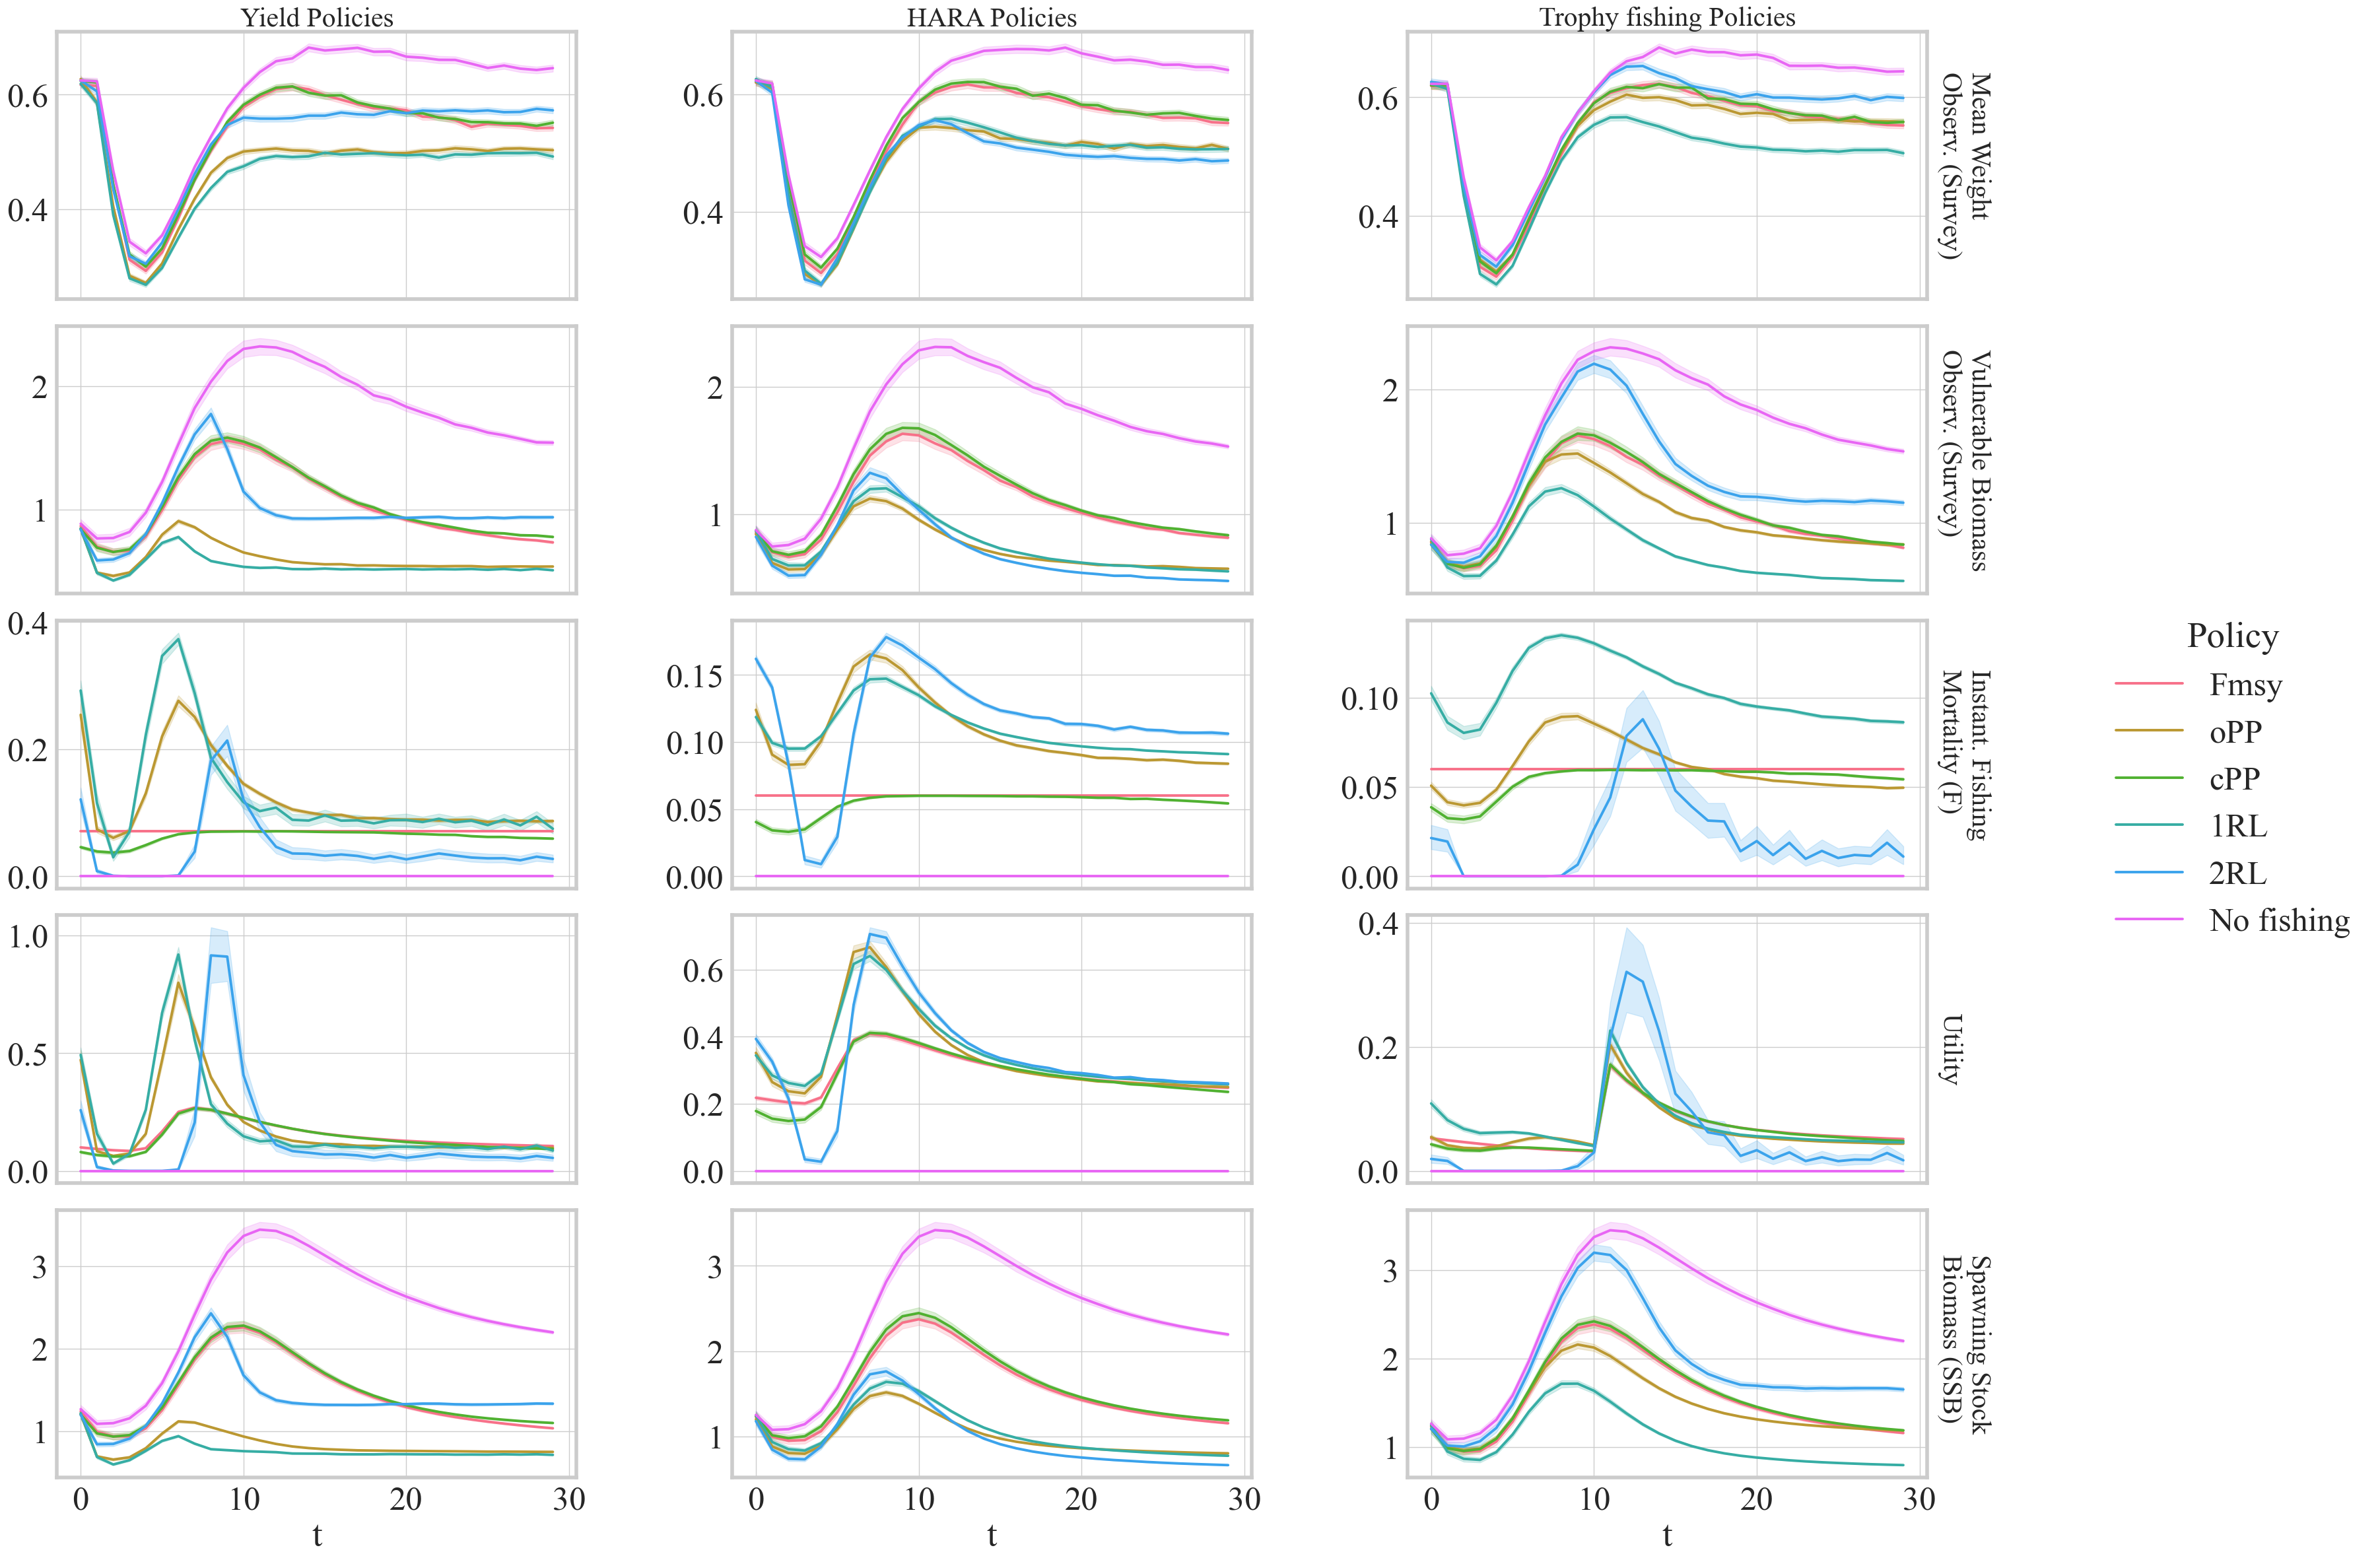

In [ ]:
g = sns.relplot(
    data=full_df,
    x='t',
    y='value',
    hue='Policy',
    row='nice_var',
    col='Utility',
    kind='line',
    aspect=2.2,
    linewidth=2.8,
    facet_kws={'sharey': False, 'margin_titles': True}
)
g.set_titles(row_template="{row_name}", col_template="{col_name} Policies", size=30)
g.set_axis_labels("t", "")
g.tight_layout()
g.figure.subplots_adjust(hspace=0.1, wspace=0.3)

mpl.rcParams['axes.linewidth'] = 4
for idx, ax in enumerate(g.axes.ravel()):
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True) 

g.savefig("../../../peer-review/myst/figures/aftermath-full.jpeg")
g

## Policy fn experiments

<Axes: xlabel='bms', ylabel='mwt'>

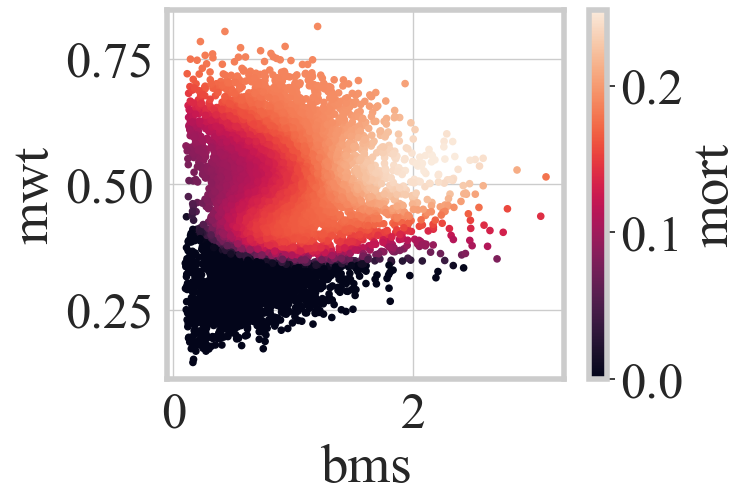

In [135]:
simulation_df_UM2[simulation_df_UM2.agent == '2RL'].plot(
    x='bms',
    y='mwt',
    c='mort',
    kind='scatter',
    
)

<Axes: xlabel='bms', ylabel='mwt'>

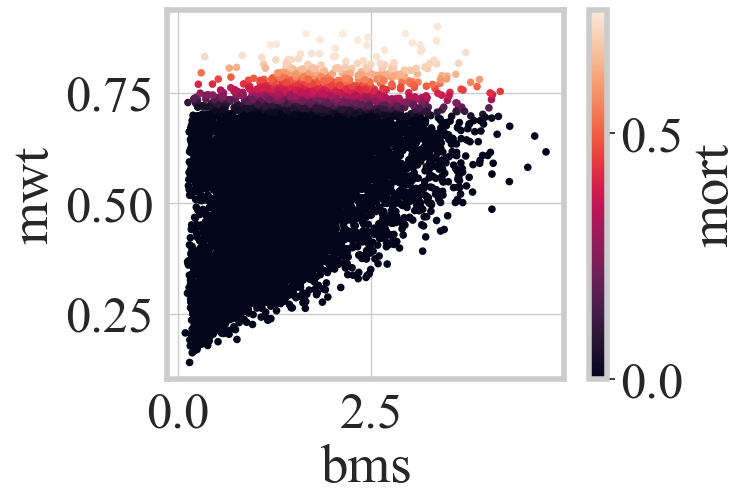

In [136]:
simulation_df_UM3[simulation_df_UM3.agent == '2RL'].plot(
    x='bms',
    y='mwt',
    c='mort',
    kind='scatter',
    
)

<Axes: xlabel='bms_', ylabel='mwt_'>

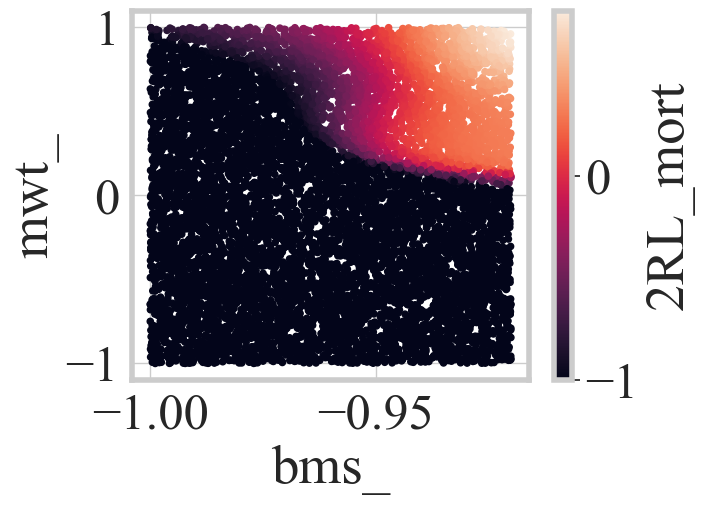

In [137]:
N_OBS = 10000
df1 = pd.DataFrame(
    {
        'bms_': [np.random.rand() * 0.08 - 1 for _ in range(N_OBS)],
        'mwt_': [np.random.rand() * 2 - 1 for _ in range(N_OBS)],
    }
)

df1['2RL_mort'] = df1.apply(
    axis =1,
    func = lambda row: UM1_Agents['2RL'].predict([row['bms_'], row['mwt_']])[0][0]
)

df1.plot(
    x='bms_',
    y='mwt_',
    c='2RL_mort',
    kind='scatter',
)

<Axes: xlabel='bms_', ylabel='mwt_'>

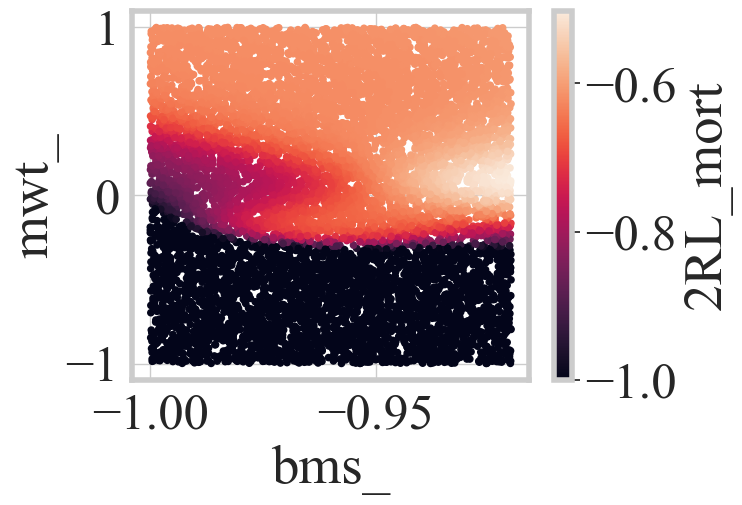

In [138]:
df2 = pd.DataFrame(
    {
        'bms_': [np.random.rand() * 0.08 - 1 for _ in range(N_OBS)],
        'mwt_': [np.random.rand() * 2 - 1 for _ in range(N_OBS)],
    }
)

df2['2RL_mort'] = df2.apply(
    axis =1,
    func = lambda row: UM2_Agents['2RL'].predict([row['bms_'], row['mwt_']])[0][0]
)

df2.plot(
    x='bms_',
    y='mwt_',
    c='2RL_mort',
    kind='scatter',
)


<Axes: xlabel='bms_', ylabel='mwt_'>

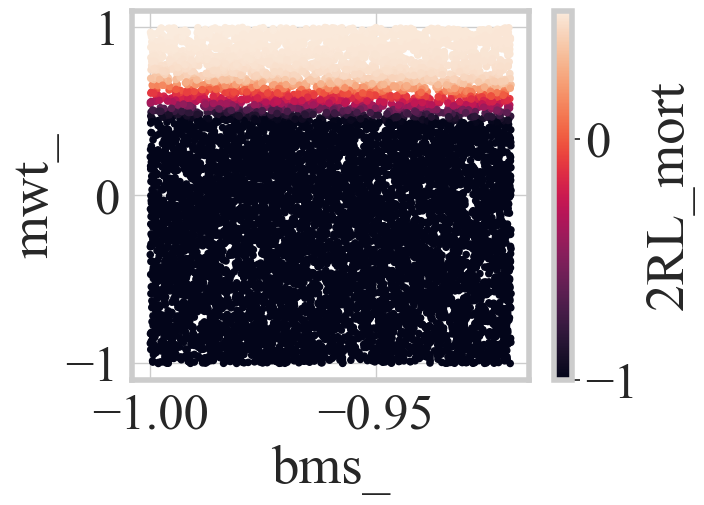

In [139]:
df3 = pd.DataFrame(
    {
        'bms_': [np.random.rand() * 0.08 - 1 for _ in range(N_OBS)],
        'mwt_': [np.random.rand() * 2 - 1 for _ in range(N_OBS)],
    }
)

df3['2RL_mort'] = df3.apply(
    axis =1,
    func = lambda row: UM3_Agents['2RL'].predict([row['bms_'], row['mwt_']])[0][0]
)

df3.plot(
    x='bms_',
    y='mwt_',
    c='2RL_mort',
    kind='scatter',
)


In [140]:
# # simulation_df_UM2.plot(
# #     x='bms',
# #     y='mwt',

# # )


# import pandas as pd
# import matplotlib.pyplot as plt

# df = simulation_df_UM2[
#     (simulation_df_UM2.agent == "2RL")
#     & (simulation_df_UM2.sim_id == 0)
# ]


# # Create the phase space plot
# plt.figure(figsize=(8, 6))
# plt.scatter(df['bms'], df['mwt'], marker='o', c=df['t'], cmap='viridis')

# # Add labels and title
# plt.xlabel('Biomass')
# plt.ylabel('Mean Wt.')
# plt.title('Phase Space Plot')

# # Add gridlines for better readability (optional)
# plt.grid(True)

# # Show the plot
# plt.show()
